In [134]:
import csv
import os
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# Import data

In [2]:
integrated_data = pd.read_csv("../data/processed/five_node_model_integrated_data.csv")

# Build model

In [144]:
print(d_posterior["posterior"]["drought_prior"][0].data[0][91:99])

[[1.02986468e-18 1.00000000e+00]
 [1.00000000e+00 4.71268346e-29]
 [1.00000000e+00 8.51027788e-24]
 [9.88528487e-01 1.14715127e-02]
 [1.00000000e+00 1.00921517e-16]
 [1.00000000e+00 2.56989288e-25]
 [1.00000000e+00 8.15357506e-36]
 [2.14408054e-21 1.00000000e+00]]


In [161]:
no_drought, drought = [], []
for index, prior_val in enumerate(d_posterior["posterior"]["drought_prior"][3].data[2]):
    if prior_val[0] > prior_val[1]:
        no_drought.append(d_posterior["posterior"]["temp_posterior"][0].data[0][index])
    else:
        drought.append(d_posterior["posterior"]["temp_posterior"][0].data[0][index])

print(np.mean(no_drought))
print(np.mean(drought))

18.81044286544486
17.854365714183626


In [175]:
no_drought_temp = []
drought_temp = []
temp_correct_predict_drought = []
temp_bad_predict_drought = []
temp_miss_prediction = []
for index, drought in enumerate(integrated_data["Drought"]):
    sample_row = d_posterior["posterior"]["drought_prior"][0].data[0][index]
    if sample_row[0] > sample_row[1]:
        sample_val = 0
    else:
        sample_val = 1
    if drought == 0:
        no_drought_temp.append(integrated_data["Unweighted_Temp"][index])
        if sample_val == 1:
            temp_bad_predict_drought.append(integrated_data["Unweighted_Temp"][index])
    else:
        drought_temp.append(integrated_data["Unweighted_Temp"][index])
        if sample_val == 1:
            temp_correct_predict_drought.append(integrated_data["Unweighted_Temp"][index])
        else:
            temp_miss_prediction.append(integrated_data["Unweighted_Temp"][index])
            
print(np.nanmean(temp_bad_predict_drought))
print(len(temp_bad_predict_drought))
print(np.nanmean(temp_correct_predict_drought))
print(len(temp_correct_predict_drought))
print(np.nanmean(temp_miss_prediction))
print(len(temp_miss_prediction))

10.706733728322952
292
21.5684612288348
570
11.440883174071429
15


In [167]:
with pm.Model() as model:

    # temperature
    # temp_prior = pm.Normal("temp_prior", 0, 30)
    # temp_std = pm.HalfNormal("temp_std", 30)
    # temp_posterior = pm.Normal("temp_posterior", temp_prior, temp_std, observed=integrated_data["Unweighted_Temp"])
    temp_mixture = pm.Dirichlet("temp_mixture", np.array([1]*3))
    temp_prior = pm.Normal("temp_prior", 0, 30, shape=(1, 3))
    temp_std = pm.HalfNormal("temp_std", 30, shape=3)
    temp_posterior = pm.NormalMixture("temp_posterior", temp_mixture, temp_prior, temp_std, observed=integrated_data["Unweighted_Temp"])
    
    # drought
    drought_coef_matrix = pm.Normal("drought_likelihood_coefs", np.zeros((len(integrated_data["Drought"]), 2)), 1)
    drought_likelihood_coefs = pt.reshape(temp_posterior, (len(integrated_data["Drought"]), 1)) * drought_coef_matrix
    drought_prior = pm.Deterministic("drought_prior", pm.math.softmax(drought_likelihood_coefs, axis=-1))
    drought_posterior = pm.Categorical("drought_posterior", drought_prior, observed=integrated_data["Drought"])

    d_prior = pm.sample_prior_predictive()
    d_trace = pm.sample()
    d_posterior = pm.sample_posterior_predictive(d_trace, extend_inferencedata=True)

/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Sampling: [drought_likelihood_coefs, drought_posterior, temp_mixture, temp_posterior_observed, temp_posterior_unobserved, temp_prior, temp_std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temp_mixture, temp_prior, temp_std, temp_posterior_unobserved, drought_likelihood_coefs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 949 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [drought_posterior, temp_posterior_observed]


In [50]:
with pm.Model() as model:

    # temperature
    temp_prior = pm.Normal("temp_prior", 0, 30)
    temp_std = pm.HalfNormal("temp_std", 30)
    temp_posterior = pm.Normal("temp_posterior", temp_prior, temp_std, observed=integrated_data["Unweighted_Temp"])

    # drought
    drought_coef_matrix = pm.Normal("drought_likelihood_coefs", np.zeros((len(integrated_data["Drought"]), 2)), 1)
    drought_likelihood_coefs = pt.reshape(temp_posterior, (len(integrated_data["Drought"]), 1)) * drought_coef_matrix
    drought_prior = pm.Deterministic("drought_prior", pm.math.softmax(drought_likelihood_coefs, axis=-1))
    drought_posterior = pm.Categorical("drought_posterior", drought_prior, observed=integrated_data["Drought"])

    # TFP
    temp_tfp_coef = pm.Normal('temp_tfp_coef',0,10)
    temp_tfp_coef2 = pm.Normal('temp_tfp_coef2',0,10)
    drought_tfp_coef = pm.Normal('drought_tfp_coef',0,10)
    tfp_intercept = pm.Normal('tfp_intercept',0,10)
    
    tfp_prior = pm.Deterministic(
        "tfp_prior", 
        tfp_intercept + 
        (temp_tfp_coef * temp_posterior) + 
        (temp_tfp_coef2 * pt.sqr(temp_posterior)) +
        (drought_tfp_coef * drought_posterior)
    )
    tfp_std = pm.HalfNormal('tfp_std', sigma=10)
    tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std, observed=integrated_data["ln_TFP_Change"])
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample()
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

with open ('../models/temp_drought_tfp.pkl', 'wb') as buff:
    pkl.dump ({'prior': prior, 'trace': trace, "posterior": posterior}, buff)

/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in tfp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x16E06DD60>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable Random

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 704 seconds.
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2A1E52660>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2A1D30200>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [drought_posterior, temp_posterior_observed, tfp_posterior_observed, tfp_posterior_unobserved]


# Load model

In [54]:
with open('../models/temp_drought_tfp.pkl', 'rb') as buff:
    data = pkl.load(buff)
    prior = data["prior"]
    trace = data["trace"]
    posterior = data["posterior"]

# Plot posterior

/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_20966/1229384700.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


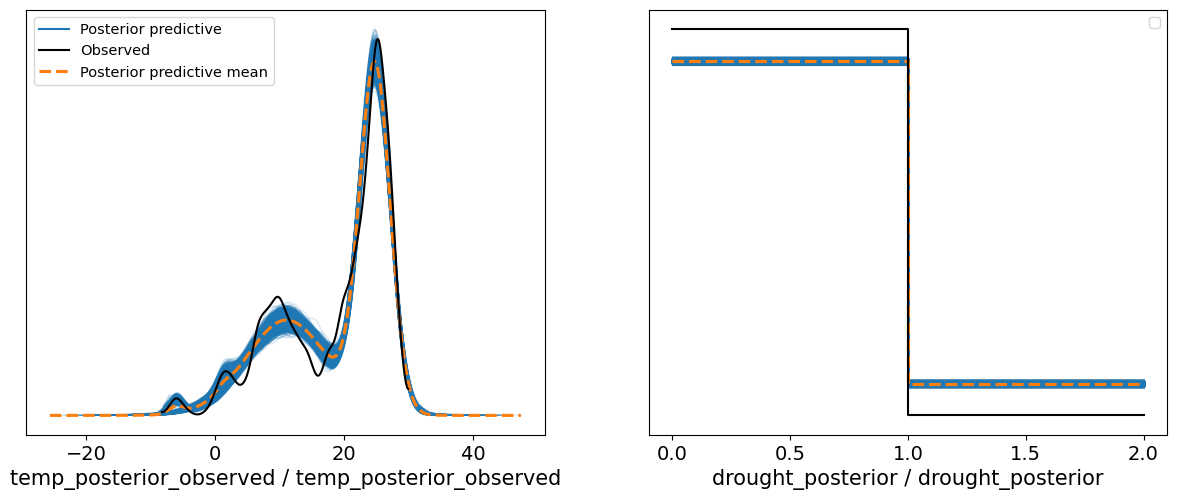

In [168]:
fig = az.plot_ppc(d_posterior).ravel()[0].figure
fig.show()

In [56]:
drought = []
no_drought = []
for i in range(1):
    for j in range(len(integrated_data["Unweighted_Temp"])):
        drought_val = posterior["posterior_predictive"]["drought_posterior"][0][i][j].data
        tfp_val = posterior["posterior_predictive"]["tfp_posterior"][0][i][j].data
        if drought_val == 0:
            no_drought.append(tfp_val)
        else:
            drought.append(tfp_val)

Probability that tfp will increase with no drought:  0.5491846396633351
Probability that tfp will increase with drought:  0.5201432408236348


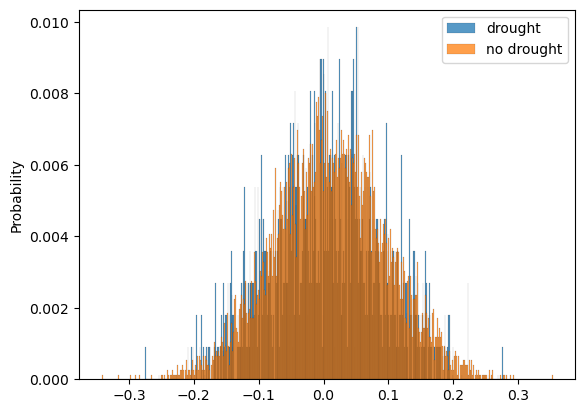

In [59]:
fig, ax = plt.subplots()
sns.histplot(data=np.array(drought), stat='probability', bins=500, ax=ax, label="drought")
sns.histplot(data=np.array(no_drought), stat='probability', bins=500, ax=ax, label="no drought")
ax.legend()
drought_area_height = [h.get_height() for h in ax.patches[:int(len(ax.patches)/2)] if h.get_x() > 0]
no_drought_area_height = [h.get_height() for h in ax.patches[int(len(ax.patches)/2):] if h.get_x() > 0]
print("Probability that tfp will increase with no drought: ", np.sum(no_drought_area_height))
print("Probability that tfp will increase with drought: ", np.sum(drought_area_height))

In [61]:
tfp_under_10 = []
tfp_over_30 = []
tfp_middle = []
for i in range(1):
    for j in range(len(integrated_data["Unweighted_Temp"])):
        temp_val = posterior["posterior_predictive"]["temp_posterior"][0][i][j].data
        tfp_val = posterior["posterior_predictive"]["tfp_posterior"][0][i][j].data
        if temp_val < 10:
            tfp_under_10.append(tfp_val)
        elif temp_val > 30:
            tfp_over_30.append(tfp_val)
        elif temp_val > 15 and temp_val < 25:
            tfp_middle.append(tfp_val)

Probability that tfp will increase with low temp:  0.554863813229572
Probability that tfp will increase with mid temp:  0.545408550467999
Probability that tfp will increase with high temp:  0.49329758713136734


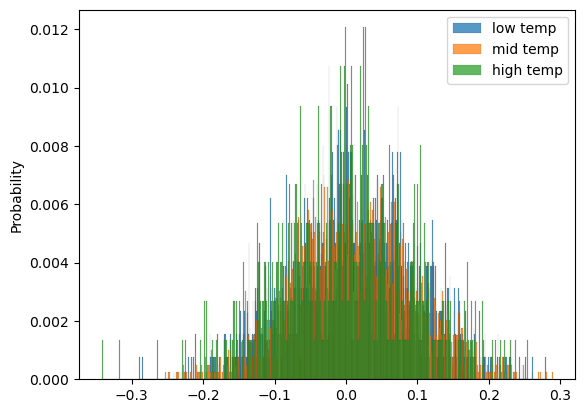

In [64]:
fig, ax = plt.subplots()
sns.histplot(data=np.array(tfp_under_10), stat='probability', bins=500, ax=ax, label="low temp")
sns.histplot(data=np.array(tfp_middle), stat='probability', bins=500, ax=ax, label="mid temp")
sns.histplot(data=np.array(tfp_over_30), stat='probability', bins=500, ax=ax, label="high temp")
ax.legend()
low_temp_height = [h.get_height() for h in ax.patches[:int(len(ax.patches)/3)] if h.get_x() > 0]
mid_temp_height = [h.get_height() for h in ax.patches[int(len(ax.patches)/3):(int(len(ax.patches)/3))*2] if h.get_x() > 0]
high_temp_height = [h.get_height() for h in ax.patches[(int(len(ax.patches)/3))*2:] if h.get_x() > 0]
print("Probability that tfp will increase with low temp: ", np.sum(low_temp_height))
print("Probability that tfp will increase with mid temp: ", np.sum(mid_temp_height))
print("Probability that tfp will increase with high temp: ", np.sum(high_temp_height))

In [173]:
drought_high_temp = []
drought_low_temp = []
for i in range(1):
    for j in range(len(integrated_data["Unweighted_Temp"])):
        temp_val = d_posterior["posterior_predictive"]["temp_posterior"][0][i][j].data
        drought_val = d_posterior["posterior_predictive"]["drought_posterior"][0][i][j].data
        if temp_val < 15:
            drought_low_temp.append(drought_val)
        elif temp_val > 20:
            drought_high_temp.append(drought_val)

In [174]:
print("Probability of drought low temp", np.mean(drought_low_temp))
print("Probability of drought high temp", np.mean(drought_high_temp))

Probability of drought low temp 0.20827389443651925
Probability of drought high temp 0.11187036313939867
